Might be useful: 
- https://github.com/sdtaylor/pyPRISMClimate
- https://gist.github.com/dbr/3351090

https://prism.oregonstate.edu/documents/PRISM_formats.pdf

https://help.arcgis.com/en/arcgisdesktop/10.0/help/index.html#//009t00000010000000

In [1]:
import datetime
import itertools
import functools
import os
import sys
import tempfile
import zipfile

from collections import defaultdict

from pathlib import Path

import numpy as np
import pandas as pd
import rasterio

In [2]:
df = pd.read_csv(
    'US_Lightning_Forest_Fires.csv',
    index_col='Unnamed: 0',
)

In [3]:
df.columns

Index(['index', 'FIRE_YEAR', 'Fire_Date', 'DISCOVERY_TIME', 'STAT_CAUSE_DESCR',
       'Days_to_extinguish_fire', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'LATITUDE', 'LONGITUDE', 'STATE', 'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

In [4]:
df.Fire_Date = pd.to_datetime(df.Fire_Date)
date_set = set(df.Fire_Date)
lat_long_pairs = set(df.apply(lambda row: (row.LATITUDE, row.LONGITUDE), axis=1))

print(len(date_set))
print(len(lat_long_pairs))
print(len(df))

6788
267707
278468


<AxesSubplot:>

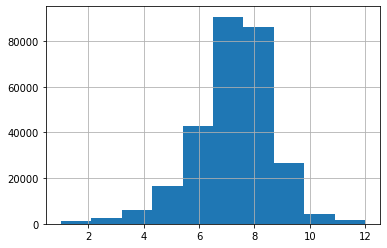

In [5]:
df.Fire_Date.dt.month.hist()

<AxesSubplot:>

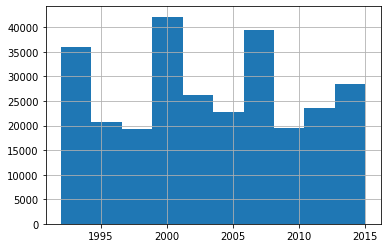

In [6]:
df.Fire_Date.dt.year.hist()

<AxesSubplot:>

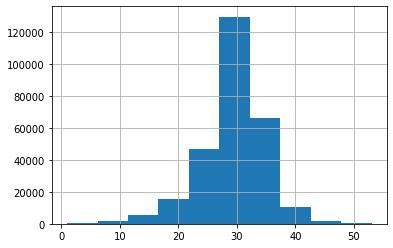

In [7]:
df.Fire_Date.dt.isocalendar().week.hist()

In [8]:
min(date_set)

Timestamp('1992-01-01 00:00:00')

In [9]:
max(date_set)

Timestamp('2015-12-26 00:00:00')

In [10]:
max(date_set) - min(date_set)

Timedelta('8760 days 00:00:00')

In [11]:
len(date_set)

6788

In [12]:
df.describe()

,index,FIRE_YEAR,DISCOVERY_TIME,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE
count,2.784680e+05,278468.000000,228272.000000,227876.000000,220068.000000,278468.000000,278468.000000,278468.000000,156911.000000
mean,6.182232e+05,2003.264210,1454.013344,2.918978,1548.339354,312.543994,39.403305,-108.226305,58.712276
std,6.038612e+05,6.642187,397.503497,11.453925,438.388579,5759.149479,6.425141,14.320107,66.980014
min,1.000000e+00,1992.000000,0.000000,-210.000000,0.000000,0.000100,17.980278,-170.369400,1.000000
25%,1.313648e+05,1998.000000,1210.000000,0.000000,1242.000000,0.100000,34.633300,-117.578143,19.000000
50%,3.307905e+05,2003.000000,1510.000000,0.000000,1608.000000,0.200000,39.491600,-111.470000,41.000000
75%,1.179343e+06,2009.000000,1730.000000,1.000000,1835.000000,2.000000,44.033070,-105.056100,77.000000
max,1.880458e+06,2015.000000,2359.000000,278.000000,2359.000000,606945.000000,70.138100,-67.158333,800.000000


In [13]:
!tree ./climate_data

./climate_data
├── max_temp
│   └── max_temp
│       ├── PRISM_tmax_stable_4kmD2_20040101_20041231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20050101_20051231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20060101_20061231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20070101_20071231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20080101_20081231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20090101_20091231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20100101_20101231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20110101_20111231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20120101_20121231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20130101_20131231_bil.zip
│       ├── PRISM_tmax_stable_4kmD2_20140101_20141231_bil.zip
│       └── PRISM_tmax_stable_4kmD2_20150101_20151231_bil.zip
├── max_vapor_pressure_deficit
│   └── max_vapor_pressure_deficit
│       ├── PRISM_vpdmax_stable_4kmD2_20040101_20041231_bil.zip
│       ├── PRISM_vpdmax_stable_4kmD2_20050101_20051231_bil.zip
│       ├── PRISM

In [14]:
interested_variables = [
    'ppt', # precipitation
    'tmean', # mean_temp
    'tmax', # max_temp
    'tmin', # min_temp
    'tdmean', # mean_dew_pt_temp
    'vpdmin', # min_vapor_pressure_deficit
    'vpdmax', # max_vapor_pressure_deficit
]

In [15]:
date_delta = 7

In [16]:
extract_dir = Path('./extracted_data')
extract_dir.mkdir(parents=True, exist_ok=True)

This section of code tracks any files that have already been extracted, so that we don't extract them again.

In [17]:
existing_files = set()
for root, dirs, files in os.walk(str(extract_dir)):
    root_path = Path(root)
    for ff in files:
        existing_files.add(str(ff))

We recursively look into folders of zip files and only extract the `.hdr` and `.bil` files.
We also make sure that we don't extract anything that exists in the `extracted_dir` already.

In [18]:
for root, dirs, files in os.walk('climate_data'):
    root_path = Path(root)
    for ff in files:
        file_path = root_path / ff
        if file_path.suffix == '.zip':
            with zipfile.ZipFile(file_path, 'r') as archive:
                for afile in archive.filelist:
                    if afile.filename in existing_files:
                        continue
                    if afile.filename.endswith('.hdr') or afile.filename.endswith('.bil'):
                        src_file = archive.extract(afile, path=extract_dir)

In [19]:
for var_name in interested_variables:
    df[var_name] = np.nan
    df[f'{var_name}-{date_delta}'] = np.nan

In [20]:
def get_data_mean(row, climate_data):
    coordinate = (row.LONGITUDE, row.LATITUDE)
    if coordinate not in climate_data:
        return np.nan

    data_list = list(climate_data[coordinate].values())
    data_list = [item for item in data_list if np.isfinite(item)]

    if not data_list:
        # no entries
        return np.nan

    return np.mean(data_list)

We use `rasterio` to read a `.bil` file.

In [21]:
count = 0
total = len(df)
start_time = datetime.datetime.now()
progress_counter = 0
progress_threshold = 10_000
for date in date_set:
    date_mask = df.Fire_Date == date
    sub_df = df[date_mask]
    
    long_lat_pairs = set(sub_df.apply(lambda row: (row.LONGITUDE, row.LATITUDE), axis=1))

    #print(len(sub_df))

    for var_name in interested_variables:
        
        climate_data = defaultdict(lambda: defaultdict(lambda: np.nan))
        
        for tdelta in range(date_delta):
            cur_date = date - pd.DateOffset(days=tdelta)
            datestr = cur_date.strftime('%Y%m%d')
            file_name = f'PRISM_{var_name}_stable_4kmD2_{datestr}_bil.bil'
            file_path = extract_dir / file_name
            
            if not file_path.exists():
                # file is not found
                continue
            
            try:
                with rasterio.open(file_path) as data:
                    data_ary = data.read()

                    (x0, y0) = data.xy(0,0)
                    (x1, y1) = data.xy(1,1)
                    # (xn, yn) = data.xy(data.width, data.height)

                    delta_x = x1-x0
                    delta_y = y1-y0

                    for (xx, yy) in long_lat_pairs:
                        if not ((data.bounds.left <= xx <= data.bounds.right) and (data.bounds.bottom <= yy <= data.bounds.top)):
                            # corrdinate is not in bounds of data
                            # skip
                            continue

                        col_index = int(round((xx - x0) / delta_x))
                        row_index = int(round((yy - y0) / delta_y))

                        if not ((0 <= row_index < data.height) and (0 <= col_index < data.width)):
                            # not in range
                            continue

                        data_val = data_ary[0,row_index,col_index]
                        if data_val == -9999:
                            # missing data value
                            # skip value
                            continue

                        climate_data[(xx,yy)][cur_date] = data_val
            except Exception as e:
                print(e, file=sys.stderr)

#         display(
#             *[
#                 [
#                     climate_data[coord][date-pd.DateOffset(days=tdelta)]
#                     for tdelta in range(date_delta)
#                 ]
#                 for coord in long_lat_pairs
#             ]
#         )

        df.loc[date_mask, var_name] = sub_df.apply(
            lambda row: climate_data[row.LONGITUDE, row.LATITUDE][cur_date],
            axis = 1,
        )
        df.loc[date_mask, f'{var_name}-{date_delta}'] = sub_df.apply(
            functools.partial(get_data_mean, climate_data=climate_data),
            axis = 1,
        )

    # display(sub_df.iloc[:,-4:])
    count += len(sub_df)

    should_print = (count // progress_threshold) > progress_counter
    progress_counter += should_print
    if should_print:
        cur_time = datetime.datetime.now()
        cur_delta = cur_time-start_time
        print(f'{cur_time}: {cur_delta} : {count} / {total} = {count/total}')

2021-12-02 23:59:33.620465: 0:01:29.218450 : 10009 / 278468 = 0.03594308861341339
2021-12-03 00:00:43.319767: 0:02:38.917752 : 20020 / 278468 = 0.07189335938061106
2021-12-03 00:01:54.558750: 0:03:50.156735 : 30032 / 278468 = 0.10784722122470086
2021-12-03 00:03:06.380727: 0:05:01.978712 : 40014 / 278468 = 0.14369335076202652
2021-12-03 00:04:10.461076: 0:06:06.059061 : 50025 / 278468 = 0.1796436215292242
2021-12-03 00:05:10.816297: 0:07:06.414282 : 60240 / 278468 = 0.21632647198241808


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:06:18.037036: 0:08:13.635021 : 70002 / 278468 = 0.2513825646034733
2021-12-03 00:07:26.183621: 0:09:21.781606 : 80000 / 278468 = 0.28728615137107316
2021-12-03 00:08:30.605401: 0:10:26.203386 : 90142 / 278468 = 0.32370685321114095
2021-12-03 00:09:26.110607: 0:11:21.708592 : 100019 / 278468 = 0.35917591967479207


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:10:27.813880: 0:12:23.411865 : 110057 / 278468 = 0.39522314951807747


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:11:31.762849: 0:13:27.360834 : 120095 / 278468 = 0.43127037936136287
2021-12-03 00:12:32.682672: 0:14:28.280657 : 130154 / 278468 = 0.4673930218193832
2021-12-03 00:13:15.512678: 0:15:11.110663 : 140135 / 278468 = 0.5032355602798168
2021-12-03 00:14:20.213979: 0:16:15.811964 : 150095 / 278468 = 0.5390026861255153
2021-12-03 00:15:12.906757: 0:17:08.504742 : 160297 / 278468 = 0.5756388525791114
2021-12-03 00:16:10.813301: 0:18:06.411286 : 170056 / 278468 = 0.6106841719694902
2021-12-03 00:17:01.130885: 0:18:56.728870 : 180047 / 278468 = 0.6465626211988451
2021-12-03 00:17:53.002208: 0:19:48.600193 : 190007 / 278468 = 0.6823297470445437


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:18:37.505685: 0:20:33.103670 : 200083 / 278468 = 0.7185134378097304
2021-12-03 00:19:30.378205: 0:21:25.976190 : 210069 / 278468 = 0.7543739316546246
2021-12-03 00:20:28.278423: 0:22:23.876408 : 220000 / 278468 = 0.7900369162704511
2021-12-03 00:21:22.874053: 0:23:18.472038 : 230154 / 278468 = 0.8265007110332246


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.
Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:22:13.289845: 0:24:08.887830 : 240033 / 278468 = 0.86197695965066


Read or write failed. extracted_data/PRISM_tdmean_stable_4kmD2_20140721_bil.bil, band 1: IReadBlock failed at X offset 0, Y offset 443: Failed to read scanline 443.


2021-12-03 00:23:07.863587: 0:25:03.461572 : 250100 / 278468 = 0.8981283307238175
2021-12-03 00:24:04.476073: 0:26:00.074058 : 260002 / 278468 = 0.9336871741097721
2021-12-03 00:24:48.235763: 0:26:43.833748 : 270128 / 278468 = 0.9700504187195657


How much fire data is missing climate data

In [22]:
len(df.dropna())/len(df)

0.27181220104284876

In [24]:
df.describe()

,index,FIRE_YEAR,DISCOVERY_TIME,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE,ppt,...,tmax,tmax-7,tmin,tmin-7,tdmean,tdmean-7,vpdmin,vpdmin-7,vpdmax,vpdmax-7
count,2.784680e+05,278468.000000,228272.000000,227876.000000,220068.000000,278468.000000,278468.000000,278468.000000,156911.000000,131469.000000,...,131469.000000,131471.000000,131469.000000,131471.000000,131395.000000,131471.000000,131469.000000,131471.000000,120487.000000,120492.000000
mean,6.182232e+05,2003.264210,1454.013344,2.918978,1548.339354,312.543994,39.403305,-108.226305,58.712276,1.159723,...,28.126682,28.696259,12.312761,12.795522,6.571763,7.178250,4.195769,4.271613,29.683108,30.574807
std,6.038612e+05,6.642187,397.503497,11.453925,438.388579,5759.149479,6.425141,14.320107,66.980014,4.231519,...,6.317697,5.513469,6.288081,5.807111,8.377103,7.619180,3.912654,3.438213,12.388688,10.674274
min,1.000000e+00,1992.000000,0.000000,-210.000000,0.000000,0.000100,17.980278,-170.369400,1.000000,0.000000,...,-12.044000,-8.421714,-25.070000,-20.154144,-22.155001,-18.173141,0.000000,0.000000,0.000000,1.197572
25%,1.313648e+05,1998.000000,1210.000000,0.000000,1242.000000,0.100000,34.633300,-117.578143,19.000000,0.000000,...,24.799000,25.685716,8.244000,9.029643,0.822000,1.962571,1.119000,1.600143,21.274500,23.364892
50%,3.307905e+05,2003.000000,1510.000000,0.000000,1608.000000,0.200000,39.491600,-111.470000,41.000000,0.000000,...,29.007000,29.358570,12.041000,12.380429,5.753000,5.950000,3.043000,3.485857,29.143999,30.094500
75%,1.179343e+06,2009.000000,1730.000000,1.000000,1835.000000,2.000000,44.033070,-105.056100,77.000000,0.086000,...,32.502998,32.553429,16.490000,16.494572,11.461500,11.126358,6.234000,6.022643,37.490002,37.252892
max,1.880458e+06,2015.000000,2359.000000,278.000000,2359.000000,606945.000000,70.138100,-67.158333,800.000000,274.108002,...,48.147999,46.906139,32.653000,31.742285,26.500000,25.960714,40.929001,35.721428,107.706001,91.770439


In [23]:
df.to_csv('forest_fire_with_climate.csv')